In [52]:
import pandas as pd
import numpy as np
# from dateutil import parser    # <-- can not use parser as we're using a 360-day calendar

from matplotlib import pyplot as plt
print(plt.style.available)
plt.style.use('classic')
%matplotlib inline


[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [34]:
### Read data
historical = pd.read_csv('Mumbai_tas_historical_HadGEM2-ES_r1i1p1.csv')
rcp26      = pd.read_csv('Mumbai_tas_rcp26_HadGEM2-ES_r1i1p1.csv')
rcp45      = pd.read_csv('Mumbai_tas_rcp45_HadGEM2-ES_r1i1p1.csv')
rcp85      = pd.read_csv('Mumbai_tas_rcp85_HadGEM2-ES_r1i1p1.csv')

In [56]:
def add_useful_time_cols(df):
    times = df['time'].values
    ntime = len(times)
    
    year, day_of_year, days_since_1800 = [], [], []

    for t in times:
        ### extract info from time string
        y,m,d = int(t[0:4]), int(t[5:7]), int(t[8:10])
        ### set year
        year = np.append(year, y)
        ### set day of year
        doy = ((m-1)*30) + d
        day_of_year = np.append(day_of_year, doy)
        ### set n days since 01-01-1800
        ds1800 = ((y-1800)*360) + doy
        days_since_1800 = np.append(days_since_1800, ds1800)
    
    ### add new columns to dateframe
    df['year'] = year.astype(int)
    df['days_since_1800'] = days_since_1800.astype(int)
    df['day_of_year'] = day_of_year.astype(int)
    
    return df

historical = add_useful_time_cols(historical)
rcp26      = add_useful_time_cols(rcp26)
rcp45      = add_useful_time_cols(rcp45)
rcp85      = add_useful_time_cols(rcp85)

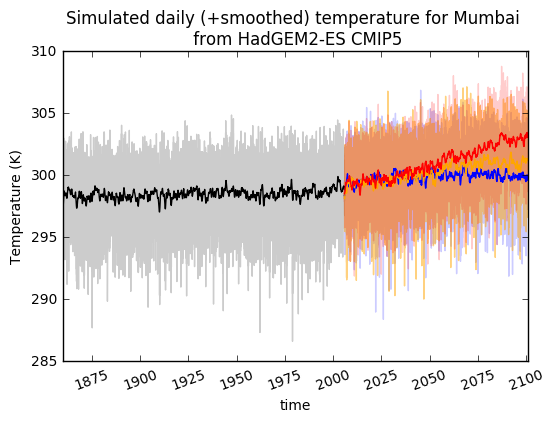

In [137]:
def lpfilter(input_signal, win):
    # Low-pass linear Filter
    # (2*win)+1 is the size of the window that determines the values that influence 
    # the filtered result, centred over the current measurement
    from scipy import ndimage
    kernel = np.lib.pad(np.linspace(1,3,win), (0,win-1), 'reflect') 
    kernel = np.divide(kernel,np.sum(kernel)) # normalise
    output_signal = ndimage.convolve(input_signal, kernel) 
    return output_signal

# ### Plot raw data
plt.plot(historical['days_since_1800'], historical['tas'], 'black',  alpha=0.2)
plt.plot(rcp26['days_since_1800'],      rcp26['tas'],      'blue',   alpha=0.2)
plt.plot(rcp45['days_since_1800'],      rcp45['tas'],      'orange', alpha=0.5)
plt.plot(rcp85['days_since_1800'],      rcp85['tas'],      'red',    alpha=0.2)

# ### plot smoothed data
plt.plot(historical['days_since_1800'], lpfilter(historical['tas'],180), 'black')
plt.plot(rcp26['days_since_1800'],      lpfilter(rcp26['tas'],180),      'blue')
plt.plot(rcp45['days_since_1800'],      lpfilter(rcp45['tas'],180),      'orange')
plt.plot(rcp85['days_since_1800'],      lpfilter(rcp85['tas'],180),      'red')

### Edit xticks
df_full_period = pd.concat([historical, rcp26])
year_xticks = df_full_period['days_since_1800'][df_full_period['day_of_year'] == 1].values
year_labels = df_full_period['year'][df_full_period['day_of_year'] == 1].values

thinned_index  = np.where( year_labels % 25 == 0)[0] # those divisible by 25
thinned_xticks = year_xticks[thinned_index]
thinned_labels = year_labels[thinned_index]
plt.xticks(thinned_xticks, thinned_labels, rotation=20)

### Add labelling
plt.title('Simulated daily (+smoothed) temperature for Mumbai \n from HadGEM2-ES CMIP5')
plt.xlabel('time')
plt.ylabel('Temperature (K)')

xlim_min, xlim_max = 1850, 2100
xlim_ind = (df_full_period['year'] >= xlim_min) & (df_full_period['year'] <= xlim_max)
xlim_range = df_full_period['days_since_1800'][xlim_ind].values
plt.xlim(np.min(xlim_range),np.max(xlim_range))

plt.ylim(285,310)

print('')
